# Pitch Tipping Via Human Pose Estimation and Time Series Classification by Justin Feldman 
## Data Exploration:
### This file is designed to help you explore your pitcher's dataset. The following supervised and unsupervised techniques to gain insights to the data are available as follows:
#### 1. General plotting of x,y landmark values per video
#### 2. Plotting of average x,y landmark values per pitch type
#### 3. T-SNE
#### 4. UMAP

In [159]:
# Loading data in. Do not touch this cell  

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_processed_data(json_file_path):
    """
    Load processed data from a JSON file back into a list of dataframes.
    
    Parameters:
    json_file_path (str): Path to the JSON file containing processed data
    
    Returns:
    list: List of dictionaries, each containing a dataframe and metadata
    """

    
    # Load the JSON data
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Convert back to the original format
    dataframes_processed = []
    
    for item in data:
        # Convert the dict records back to a DataFrame
        df = pd.DataFrame(item['dataframe'])
        
        # Create the same structure as the original dataframes_processed
        dataframes_processed.append({
            'dataframe': df,
            'pitch_type': item['pitch_type'],
            'video_index': item['video_index'],
            'filename': item['filename']
        })
    
    return dataframes_processed

#### Add pitcher name and processed data path from main data acquisition file. 

In [160]:
pitcher_name = 'Nestor Cortes'
processed_data_path = '/Users/justinfeldman/Library/Mobile Documents/com~apple~CloudDocs/CS6140/Final Project/Pitcher Data/Cortes_Nestor/cortes_nestor_processed.json'
dataframes = load_processed_data(processed_data_path)

## 1. General plotting of x,y landmark values per video

In [161]:
# Do not touch this cell
def general_plotting(video_of_interest, landmarks_of_interest):
    target_dataframe = dataframes[video_of_interest]['dataframe']

    frame_axis = np.linspace(0, 100, 25)
    x_data_list = []
    y_data_list = []
    for landmark in landmarks_of_interest:
        x_data_list.append(target_dataframe[f'{landmark}_x'])
        y_data_list.append(target_dataframe[f'{landmark}_y'])

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    plt.suptitle(f'Video {video_of_interest} Landmark Coordinates per Frame')
    
    for i in range(len(x_data_list)):
        axs[0].plot(frame_axis, x_data_list[i], label=landmarks_of_interest[i])
        axs[1].plot(frame_axis, y_data_list[i], label=landmarks_of_interest[i])
    
    axs[0].set_ylabel('x-coord. (inches)')
    axs[1].set_ylabel('y-coord. (inches)')
    axs[1].set_xlabel('Frame (60 FPS)')
    axs[0].grid(True)
    axs[1].grid(True)
  
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5))
    plt.tight_layout()
    plt.show()

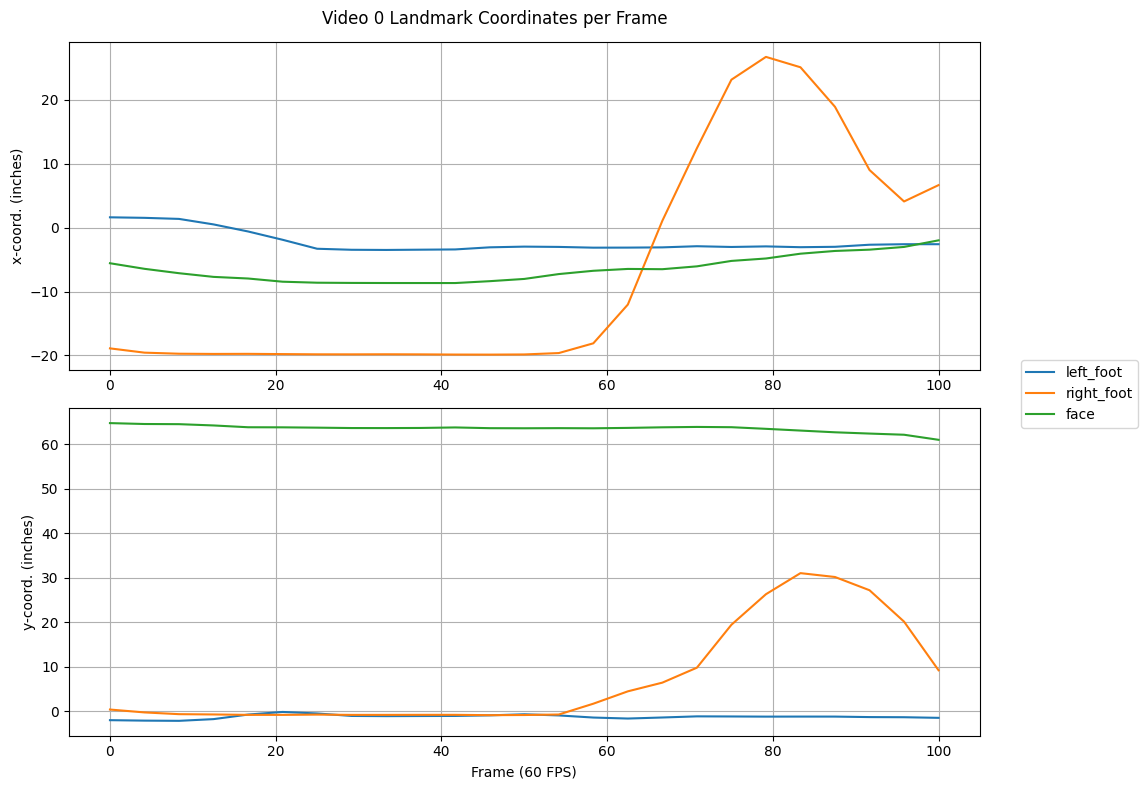

In [162]:
landmarks = {
    0: 'left_shoulder',
    1: 'right_shoulder',
    2: 'left_elbow',
    3: 'right_elbow',
    4: 'left_hip',
    5: 'right_hip',
    6: 'left_knee',
    7: 'right_knee',
    8: 'face',
    9: 'left_hand',
    10: 'right_hand',
    11: 'left_foot',
    12: 'right_foot'
}

# Use the mapping above to create an array of landmarks you want to observe. Choose a video you want to observe as well.
# Data Wrangler is a very helpful plug-in to visualize the datadrames and choose a video of interest
landmarks_to_plot = [11,12,8]
video_of_interest = 0

landmarks_of_interest = []
for i in landmarks_to_plot:
    landmarks_of_interest.append(landmarks[i])

general_plotting(video_of_interest, landmarks_of_interest)

## 2. Plotting of average x,y landmark values per pitch type

In [163]:
# Do not touch this cell
def analyze_landmark_by_pitch_and_frame(dataframes, landmark_name):

    pitch_data = {}
    
    for video_data in dataframes:
        pitch_type = video_data['pitch_type']
        df = video_data['dataframe']
        
        x_col = f"{landmark_name}_x"
        y_col = f"{landmark_name}_y"
        
        if x_col in df.columns and y_col in df.columns:
            if pitch_type not in pitch_data:
                pitch_data[pitch_type] = {
                    'x_values': {i: [] for i in range(25)},  
                    'y_values': {i: [] for i in range(25)},
                    'video_count': 0
                }
            
            pitch_data[pitch_type]['video_count'] += 1
            
            for frame_idx in range(min(25, len(df))):
                if frame_idx < len(df):
                    pitch_data[pitch_type]['x_values'][frame_idx].append(df.iloc[frame_idx][x_col])
                    pitch_data[pitch_type]['y_values'][frame_idx].append(df.iloc[frame_idx][y_col])
    
    for pitch_type in pitch_data:
        pitch_data[pitch_type]['x_avg'] = np.zeros(25)
        pitch_data[pitch_type]['y_avg'] = np.zeros(25)
        
        for frame_idx in range(25):
            x_values = pitch_data[pitch_type]['x_values'][frame_idx]
            y_values = pitch_data[pitch_type]['y_values'][frame_idx]
            
            if x_values and y_values:  
                pitch_data[pitch_type]['x_avg'][frame_idx] = np.mean(x_values)
                pitch_data[pitch_type]['y_avg'][frame_idx] = np.mean(y_values)
    
    return pitch_data

def landmark_averages_by_pitch(dataframes, landmark):
 
    pitch_data = analyze_landmark_by_pitch_and_frame(dataframes, landmark)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    colors = plt.cm.tab10.colors
    
    frames = np.linspace(0,100,25)
    
    for i, (pitch_type, data) in enumerate(pitch_data.items()):
        color = colors[i % len(colors)]
        
        x_avg = data['x_avg']
        y_avg = data['y_avg']
        
        axs[0].plot(frames, x_avg, color=color, label=f"{pitch_type} (n={data['video_count']})")
        axs[1].plot(frames, y_avg, color=color, label=f"{pitch_type} (n={data['video_count']})")
    
    axs[0].set_ylabel("X-Coordinate (inches)")
    axs[1].set_ylabel("Y-Coordinate (inches)")
    axs[1].set_xlabel("Frame (60 FPS)")

    axs[0].grid(True)
    axs[1].grid(True)
    
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5))
    fig.suptitle(f"{landmark} Average Movement Patterns by Pitch Type")
    plt.tight_layout()
    plt.show()

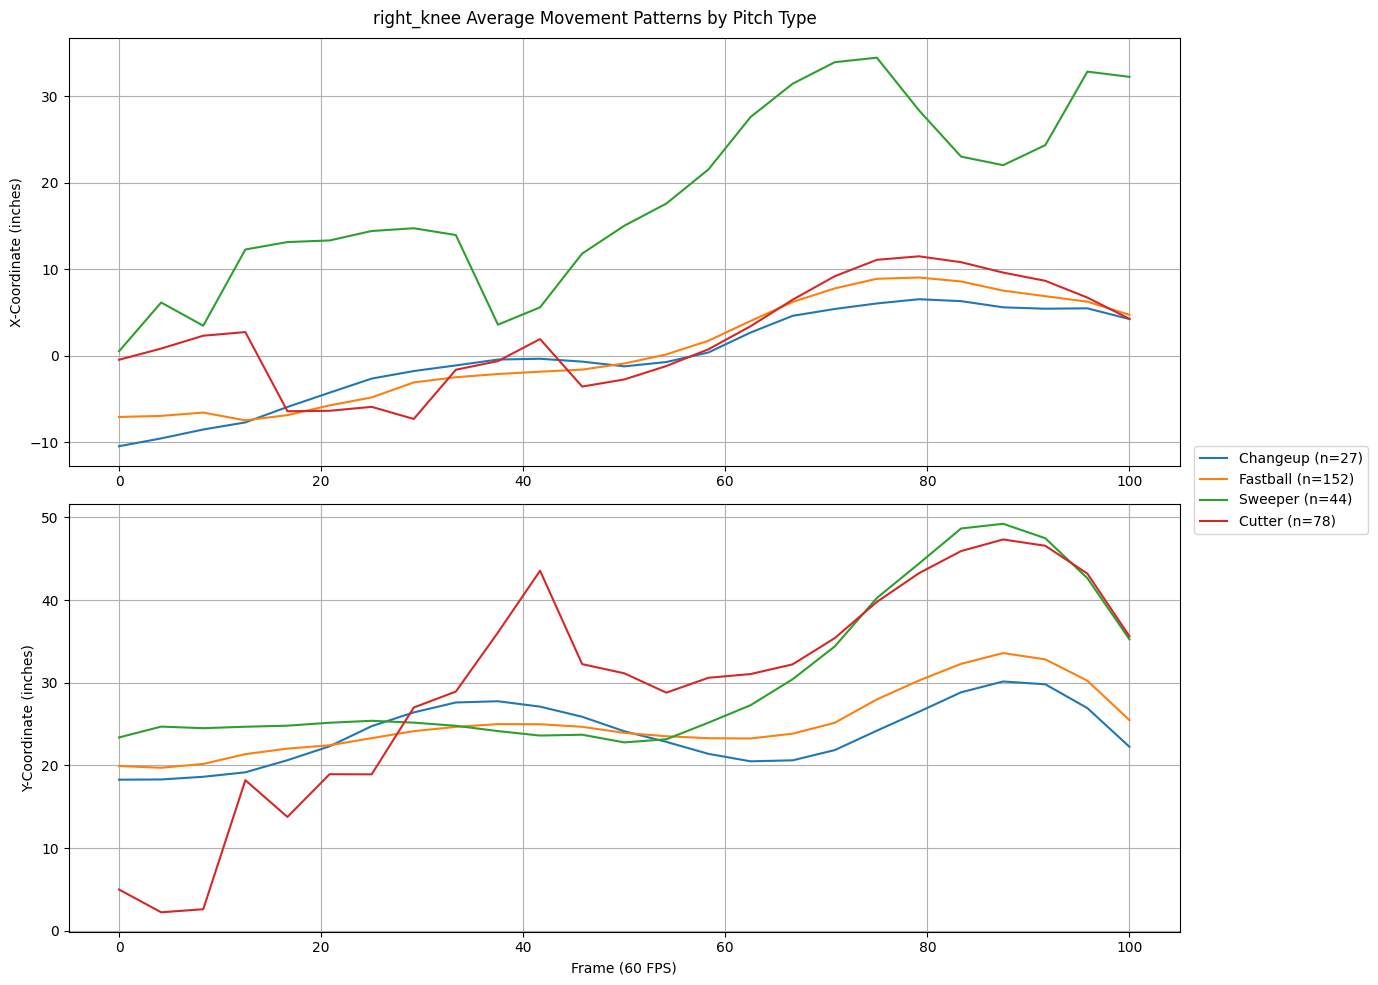

In [164]:
landmarks = {
    0: 'left_shoulder',
    1: 'right_shoulder',
    2: 'left_elbow',
    3: 'right_elbow',
    4: 'left_hip',
    5: 'right_hip',
    6: 'left_knee',
    7: 'right_knee',
    8: 'face',
    9: 'left_hand',
    10: 'right_hand',
    11: 'left_foot',
    12: 'right_foot'
}

# Add digit to landmarks [#]
landmark = landmarks[7]

landmark_averages_by_pitch(dataframes, landmark)

## 3. T-SNE

This section implements a powerful unsupervised machine learning method:

- **t-Distributed Stochastic Neighbor Embedding**: Effective for visualizing high-dimensional data by reducing the dimensionality of the data points while keeping their relative higher dimension distance from eachother using probabilistic groupings. [Read more...](https://medium.com/@sachinsoni600517/mastering-t-sne-t-distributed-stochastic-neighbor-embedding-0e365ee898ea)

Start by focusing on the lower body vs upper body and see where a more telling feature may lie. Then try to focus on one landmark at a time and see if there's one that differentiates the pitches more than the others. 

perplexity is the hyperparameter that essentially determines the number of neighbors to be considered at each point. It either emphasizes local structure of the data or the global structure of the data. Try values between 5-50 in increments of 5.

The more the colors are separated, the better the indicator that more blatant pitch-tipping is occurring. If you see different clusters where the colors are not well separated, that is likely due to your pitcher's variety in motion and not because he's tipping his pitches. (i.e. stretch, slide-step from stretch, full leg-lift in stretch, full windup) 

In [165]:
# Do not touch this cell
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def flatten_data_for_analysis(dataframes, landmarks):
    
    if landmarks_of_interest is None:
        print("Provide a landmark(s) you would like to analyze.")
        return
    
    # Lists to store features and targets
    all_features = []
    all_targets = []
    
    # Process each video
    for video_data in dataframes:
        pitch_type = video_data['pitch_type']
        df = video_data['dataframe']
        
        # Initialize a list for this video's flattened features
        video_features = []
        
        # For each frame, extract and flatten selected landmark coordinates
        for frame_idx in range(len(df)):
            frame_data = df.iloc[frame_idx]
            
            # Extract coordinates for selected landmarks
            for landmark in landmarks:
                # Find the relevant coordinate columns for this landmark
                x_col = f'{landmark}_x'
                y_col = f'{landmark}_y'
                presence_col = f'{landmark}_presence'
                
                # Add x and y coordinates to features
                video_features.append(frame_data[x_col])
                video_features.append(frame_data[y_col])
                video_features.append(frame_data[presence_col])
        
        # Add this video's features to the lists
        all_features.append(video_features)
        all_targets.append(pitch_type)
    
    # Create DataFrames
    X_pitches = pd.DataFrame(all_features)
    y_pitches = pd.Series(all_targets, name='pitch_type')
    
    return X_pitches, y_pitches

def tsne_visualization(dataframes, pitcher_name, perplexity, landmarks_of_interest):
    landmark_map = {
        0: 'left_shoulder',
        1: 'right_shoulder',
        2: 'left_elbow',
        3: 'right_elbow',
        4: 'left_hip',
        5: 'right_hip',
        6: 'left_knee',
        7: 'right_knee',
        8: 'face',
        9: 'left_hand',
        10: 'right_hand',
        11: 'left_foot',
        12: 'right_foot'
    }
    landmarks = []
    for landmark in landmarks_of_interest:
        add_landmark = landmark_map[landmark]
        landmarks.append(add_landmark)

    X_pitches, y_pitches = flatten_data_for_analysis(dataframes, landmarks)
    scaling = StandardScaler()
    scaled_X_pitches = scaling.fit_transform(X_pitches)

    tsne_2D = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_pitches_2D = tsne_2D.fit_transform(scaled_X_pitches)
    
    tsne_3D = TSNE(n_components=3, perplexity=perplexity, random_state=42)
    X_pitches_3D = tsne_3D.fit_transform(scaled_X_pitches)
    
    # Create DataFrame for plotting
    df_2D = pd.DataFrame(X_pitches_2D, columns=['x', 'y'])
    df_2D['pitch_type'] = y_pitches
    
    df_3D = pd.DataFrame(X_pitches_3D, columns=['x', 'y', 'z'])
    df_3D['pitch_type'] = y_pitches
    
    # 2D Interactive Plot
    fig_2D = px.scatter(
        df_2D, 
        x='x', 
        y='y', 
        color='pitch_type', 
        title=f'2D t-SNE Visualization for {pitcher_name} (Perplexity = {perplexity}, Landmarks: {landmarks})',
        labels={'x': 't-SNE Feature 1', 'y': 't-SNE Feature 2'}
    )

    fig_2D.show()
    
    # 3D Interactive Plot
    fig_3D = px.scatter_3d(
        df_3D, 
        x='x', 
        y='y', 
        z='z', 
        color='pitch_type', 
        title=f'3D t-SNE Visualization for {pitcher_name} (Perplexity = {perplexity}, Landmarks: {landmarks})',
        labels={'x': 't-SNE Feature 1', 'y': 't-SNE Feature 2', 'z': 't-SNE Feature 3'}
    )
    
    fig_3D.update_traces(
        marker=dict(size=5),
        selector=dict(mode='markers')
    )
    
    fig_3D.update_traces(
        hovertemplate='<b>Pitch Type</b>: %{text}<br>' +
                      '<b>X</b>: %{x:.3f}<br>' +
                      '<b>Y</b>: %{y:.3f}<br>' +
                      '<b>Z</b>: %{z:.3f}',
        text=df_3D['pitch_type']
    )
    
    fig_3D.update_layout(
        scene=dict(
            xaxis_title='t-SNE Feature 1',
            yaxis_title='t-SNE Feature 2',
            zaxis_title='t-SNE Feature 3'
        )
    )
    
    fig_3D.show()
    
    return fig_2D, fig_3D

In [166]:
landmarks = {
    0: 'left_shoulder',
    1: 'right_shoulder',
    2: 'left_elbow',
    3: 'right_elbow',
    4: 'left_hip',
    5: 'right_hip',
    6: 'left_knee',
    7: 'right_knee',
    8: 'face',
    9: 'left_hand',
    10: 'right_hand',
    11: 'left_foot',
    12: 'right_foot'
}

all = [0,1,2,3,4,5,6,7,8,9,10,11,12]
upper_body = [0,1,2,3,8,9,10]
lower_body = [4,5,6,7,11,12]
user_defined = [] # Add your own 

landmarks_of_interest = lower_body
perplexity = 10

tsne_visualization(dataframes, pitcher_name, perplexity, landmarks_of_interest)

(Figure({
     'data': [{'hovertemplate': ('pitch_type=Changeup<br>t-SNE F' ... ' Feature 2=%{y}<extra></extra>'),
               'legendgroup': 'Changeup',
               'marker': {'color': '#636efa', 'symbol': 'circle'},
               'mode': 'markers',
               'name': 'Changeup',
               'orientation': 'v',
               'showlegend': True,
               'type': 'scatter',
               'x': array([-21.014044 ,  -7.869603 ,  47.11204  , -25.76593  ,  24.42447  ,
                            -6.2270565, -22.585188 ,  44.297005 , -20.233582 ,  -0.9884695,
                           -23.342018 ,  39.74483  , -19.844526 ,  40.391438 ,  46.4161   ,
                            46.410492 , -24.468391 ,  49.421833 , -11.529527 ,  27.00605  ,
                            30.028568 , -17.079664 ,  27.965319 , -19.904764 ,  45.937954 ,
                            -6.1961956, -23.451221 ], dtype=float32),
               'xaxis': 'x',
               'y': array([ 2.05426102e+01, 

## 4. UMAP

This section implements a powerful unsupervised machine learning method, newer and more efficient than TSNE:

- **Uniform Manifold Approximation and Projection (UMAP)**: Effective for visualizing high-dimensional data by creating a graphical implementation of the points in the higher dimension and recreating that graph in the lower dimension with as similar a structure as possible. [Read more...](https://pair-code.github.io/understanding-umap/)

Choose a landmark or two and change the perplexity value below for different visualizations of the results.  

Start by focusing on the lower body vs upper body and see where a more telling feature may lie. Then try to focus on one landmark at a time and see if there's one that differentiates the pitches more than the others. 

n_neighbors and min_dist hyperparameters help define the graphical structure at the higher dimension. Try values between 10-30 in increments of 5 and 0-1 in increments of 0.1 respectively.

The more the colors are separated, the better the indicator that more blatant pitch-tipping is occurring. If you see different clusters where the colors are not well separated, that is likely due to your pitcher's variety in motion and not because he's tipping his pitches. (i.e. stretch, slide-step from stretch, full leg-lift in stretch, full windup) 

In [167]:
import umap  # pip install umap-learn if you do not have Python 10 or Python 11

def umap_visualization(dataframes, pitcher_name, n_neighbors, min_dist, landmarks_of_interest):
    landmark_map = {
        0: 'left_shoulder',
        1: 'right_shoulder',
        2: 'left_elbow',
        3: 'right_elbow',
        4: 'left_hip',
        5: 'right_hip',
        6: 'left_knee',
        7: 'right_knee',
        8: 'face',
        9: 'left_hand',
        10: 'right_hand',
        11: 'left_foot',
        12: 'right_foot'
    }
    
    if landmarks_of_interest is None:
        print("Provide a landmark(s) you would like to analyze.")
        return None, None
    
    landmarks = []
    for landmark in landmarks_of_interest:
        add_landmark = landmark_map[landmark]
        landmarks.append(add_landmark)

    X_pitches, y_pitches = flatten_data_for_analysis(dataframes, landmarks)
    
    scaling = StandardScaler()
    scaled_X_pitches = scaling.fit_transform(X_pitches)

    umap_2D = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
    X_pitches_2D = umap_2D.fit_transform(scaled_X_pitches)
    
    umap_3D = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=3, random_state=42)
    X_pitches_3D = umap_3D.fit_transform(scaled_X_pitches)
    
    df_2D = pd.DataFrame(X_pitches_2D, columns=['x', 'y'])
    df_2D['pitch_type'] = y_pitches
    
    df_3D = pd.DataFrame(X_pitches_3D, columns=['x', 'y', 'z'])
    df_3D['pitch_type'] = y_pitches
    
    fig_2D = px.scatter(
        df_2D, 
        x='x', 
        y='y', 
        color='pitch_type', 
        title=f'2D UMAP Visualization for {pitcher_name} (n_neighbors={n_neighbors}, min_dist={min_dist}, Landmarks: {landmarks})',
        labels={'x': 'UMAP Feature 1', 'y': 'UMAP Feature 2'}
    )

    fig_2D.update_traces(
        hovertemplate='<b>Pitch Type</b>: %{text}<br>' +
                      '<b>X</b>: %{x:.3f}<br>' +
                      '<b>Y</b>: %{y:.3f}',
        text=df_2D['pitch_type']
    )
    
    fig_3D = px.scatter_3d(
        df_3D, 
        x='x', 
        y='y', 
        z='z', 
        color='pitch_type', 
        title=f'3D UMAP Visualization for {pitcher_name} (n_neighbors={n_neighbors}, min_dist={min_dist}, Landmarks: {landmarks})',
        labels={'x': 'UMAP Feature 1', 'y': 'UMAP Feature 2', 'z': 'UMAP Feature 3'}
    )
    
    fig_3D.update_traces(
        marker=dict(size=5),
        selector=dict(mode='markers')
    )
    
    fig_3D.update_traces(
        hovertemplate='<b>Pitch Type</b>: %{text}<br>' +
                      '<b>X</b>: %{x:.3f}<br>' +
                      '<b>Y</b>: %{y:.3f}<br>' +
                      '<b>Z</b>: %{z:.3f}',
        text=df_3D['pitch_type']
    )
    
    fig_3D.update_layout(
        scene=dict(
            xaxis_title='UMAP Feature 1',
            yaxis_title='UMAP Feature 2',
            zaxis_title='UMAP Feature 3'
        )
    )

    fig_2D.show()
    fig_3D.show()
    
    return fig_2D, fig_3D

In [169]:
landmarks = {
    0: 'left_shoulder',
    1: 'right_shoulder',
    2: 'left_elbow',
    3: 'right_elbow',
    4: 'left_hip',
    5: 'right_hip',
    6: 'left_knee',
    7: 'right_knee',
    8: 'face',
    9: 'left_hand',
    10: 'right_hand',
    11: 'left_foot',
    12: 'right_foot'
}

all = [0,1,2,3,4,5,6,7,8,9,10,11,12]
upper_body = [0,1,2,3,8,9,10]
lower_body = [4,5,6,7,11,12]
user_defined = [] # Add your own 

landmarks_of_interest = upper_body
n_neighbors = 30
min_dist = 0.5

umap_visualization(dataframes, pitcher_name, n_neighbors, min_dist, landmarks_of_interest)

/opt/miniconda3/envs/CS100Program1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/miniconda3/envs/CS100Program1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(Figure({
     'data': [{'hovertemplate': '<b>Pitch Type</b>: %{text}<br><b>X</b>: %{x:.3f}<br><b>Y</b>: %{y:.3f}',
               'legendgroup': 'Changeup',
               'marker': {'color': '#636efa', 'symbol': 'circle'},
               'mode': 'markers',
               'name': 'Changeup',
               'orientation': 'v',
               'showlegend': True,
               'text': array(['Changeup', 'Changeup', 'Changeup', ..., 'Cutter', 'Cutter', 'Cutter'],
                             dtype=object),
               'type': 'scatter',
               'x': array([ 3.692242  ,  4.7615104 , -2.4149628 ,  3.4465282 , -0.6414345 ,
                            4.2102957 ,  4.649917  , -1.4819447 ,  3.584169  ,  6.375079  ,
                            3.1919837 , -2.7037466 ,  5.8115134 , -2.5602698 , -2.259487  ,
                           -2.7579308 ,  3.3669643 , -2.1872454 ,  5.703978  , -0.7833466 ,
                            0.06841799,  3.729173  , -1.4240685 ,  4.1695833 , -2.466287